In [1]:
import sys, os

import glob
import numpy as np
import xarray as xr

import joblib

import lnpy
import thermoextrap

import matplotlib.pyplot as plt

from thermoextrap.gpr_active import active_utils

2022-11-18 11:04:46.047129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Preliminaries

In [2]:
base_dir = 'SRS_data'
raw_dat = np.loadtxt('SRS_data/SRS_LJ_VLE_data.txt')
raw_beta = 1.0 / raw_dat[::-1, 0]
raw_psat = raw_dat[::-1, 5]
raw_dens = raw_dat[::-1, [1, 3]]
raw_lnz = raw_dat[::-1, -2]

In [3]:
from run_LJ_lnPi import *

# Macrostate extrapolation

In [4]:
ref_T = [0.7, 1.2]

ref_mu = np.average([get_sim_activity(t)*t for t in ref_T])
print(ref_mu)

lnpi_info = [load_lnPi_info(t, ref_mu=ref_mu) for t in ref_T]
state_list = [state_from_info_dict(i) for i in lnpi_info]

-3.9875


In [5]:
gp_model = active_utils.create_GPR(state_list)

2022-11-18 11:04:56.543533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
gp_model

name,class,transform,prior,trainable,shape,dtype,value
HeteroscedasticGPR.kernel.kernel.var,Parameter,Softplus,,True,(),float64,5.54628
HeteroscedasticGPR.kernel.kernel.l,Parameter,Softplus,,True,(),float64,0.496656
HeteroscedasticGPR.likelihood.power_scale,Parameter,Softplus,,True,(),float64,3.40188
HeteroscedasticGPR.likelihood.power_add,Parameter,Identity,,False,(),float64,0


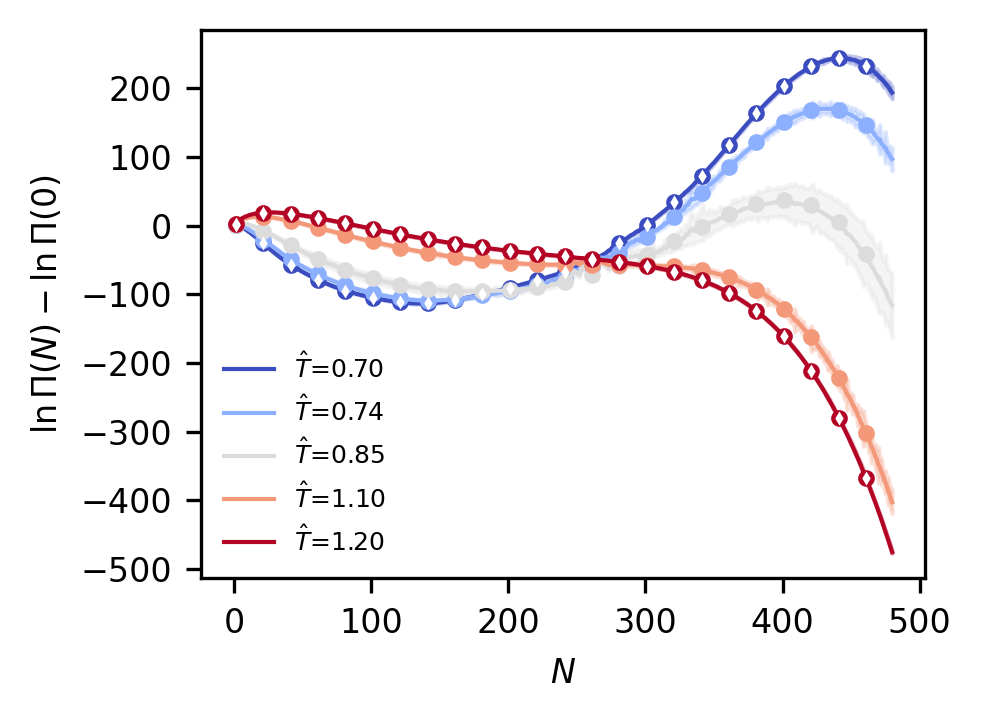

In [7]:
%matplotlib inline

#Now look at predictions with GP model
test_T = np.array([0.70, 0.74, 0.85, 1.10, 1.20])
test_beta = 1.0/test_T

gp_mu, gp_var = gp_model.predict_f(np.vstack([test_beta, np.zeros_like(test_beta)]).T)
gp_mu = gp_mu.numpy()
gp_var = gp_var.numpy()
gp_std = np.sqrt(gp_var)

#Add N=0 bin back in
gp_mu = np.concatenate([np.zeros((gp_mu.shape[0], 1)), gp_mu], axis=-1)
gp_var = np.concatenate([np.zeros((gp_var.shape[0], 1)), gp_var], axis=-1)
gp_std = np.concatenate([np.zeros((gp_std.shape[0], 1)), gp_std], axis=-1)

N_vals = np.arange(gp_mu.shape[1])

tColors = plt.cm.coolwarm(np.linspace(0.0, 1.0, len(test_T)))

fig, ax = plt.subplots(figsize=(3.37, 2.5), dpi=300)

for i in range(len(test_T)):

    this_pred = gp_mu[i, :]
    ax.fill_between(N_vals,
                    this_pred - 2.0*gp_std[i, :],
                    this_pred + 2.0*gp_std[i, :],
                    color=tColors[i], alpha=0.3)
    ax.plot(N_vals, this_pred, linewidth=1.0, color=tColors[i], label=r'$\hat{T}$=%1.2f'%test_T[i])
        
    this_true = np.average(load_lnPi_info(test_T[i], ref_mu=ref_mu)['lnPi'], axis=0)
    ax.plot(N_vals[1::20], this_true[1::20], 'o', color=tColors[i], ms=3.0)

max_order = int(np.max(gp_model.data[0][:, 1]))
for i in range(len(ref_T)):
    this_ref = gp_model.data[1][i*(max_order+1), :] * gp_model.scale_fac
    ax.plot(N_vals[1::20], this_ref[::20], 'dw', ms=1.0)

ax.tick_params(axis='both', labelsize=8)

ax.legend(fontsize=6, frameon=False)

ax.set_xlabel(r'$N$', fontsize=8)
ax.set_ylabel(r'$\ln \Pi (N) - \ln \Pi (0)$', fontsize=8)

fig.tight_layout()

plt.show()

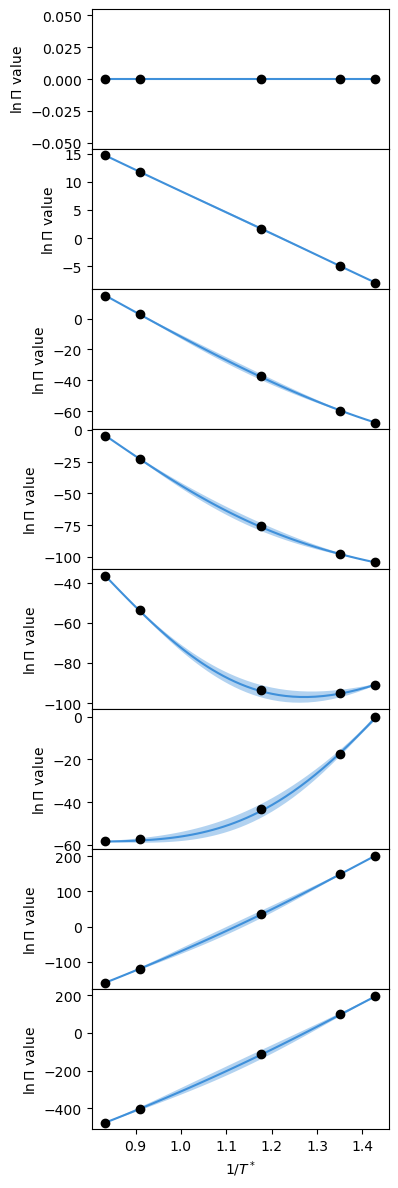

In [8]:
extra_T = np.linspace(0.7, 1.2, 50)
extra_betas = 1.0 / extra_T

extra_mu, extra_var = gp_model.predict_f(np.vstack([extra_betas, np.zeros_like(extra_betas)]).T)
extra_mu = extra_mu.numpy()
extra_var = extra_var.numpy()
extra_std = np.sqrt(extra_var)

#Add N=0 bin back in
extra_mu = np.concatenate([np.zeros((extra_mu.shape[0], 1)), extra_mu], axis=-1)
extra_var = np.concatenate([np.zeros((extra_var.shape[0], 1)), extra_var], axis=-1)
extra_std = np.concatenate([np.zeros((extra_std.shape[0], 1)), extra_std], axis=-1)

check_inds = [0, 10, 50, 100, 200, 300, 400, -1]

true_lnPis = np.array([np.average(load_lnPi_info(t, ref_mu=ref_mu)['lnPi'], axis=0)
                       for t in test_T])

fig, ax = plt.subplots(len(check_inds), figsize=(4.0, 1.5*len(check_inds)), sharex=True)

for i, ind in enumerate(check_inds):
    
    ax[i].plot(extra_betas, extra_mu[:, ind])
    ax[i].fill_between(extra_betas, extra_mu[:, ind]-extra_std[:, ind], extra_mu[:, ind]+extra_std[:, ind], alpha=0.4)
    ax[i].plot(test_beta, true_lnPis[:, ind], 'ko')

    ax[i].set_xlabel(r'$1/T^*$')
    ax[i].set_ylabel(r'$\ln \Pi$ value')
    
fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

# Saturation Properties

In [9]:
#Load saturation properties
#Should be lnz, density_gas, density_liquid, pressure_gas, pressure_liquid
sat_props = np.load(os.path.expanduser('~/GPR_Extrapolation/LJ_EOS/lnPi/sat_props_GPR.npz'))
gp_sat_props = sat_props['props']
gp_sat_props_conf_ints = sat_props['conf_ints']

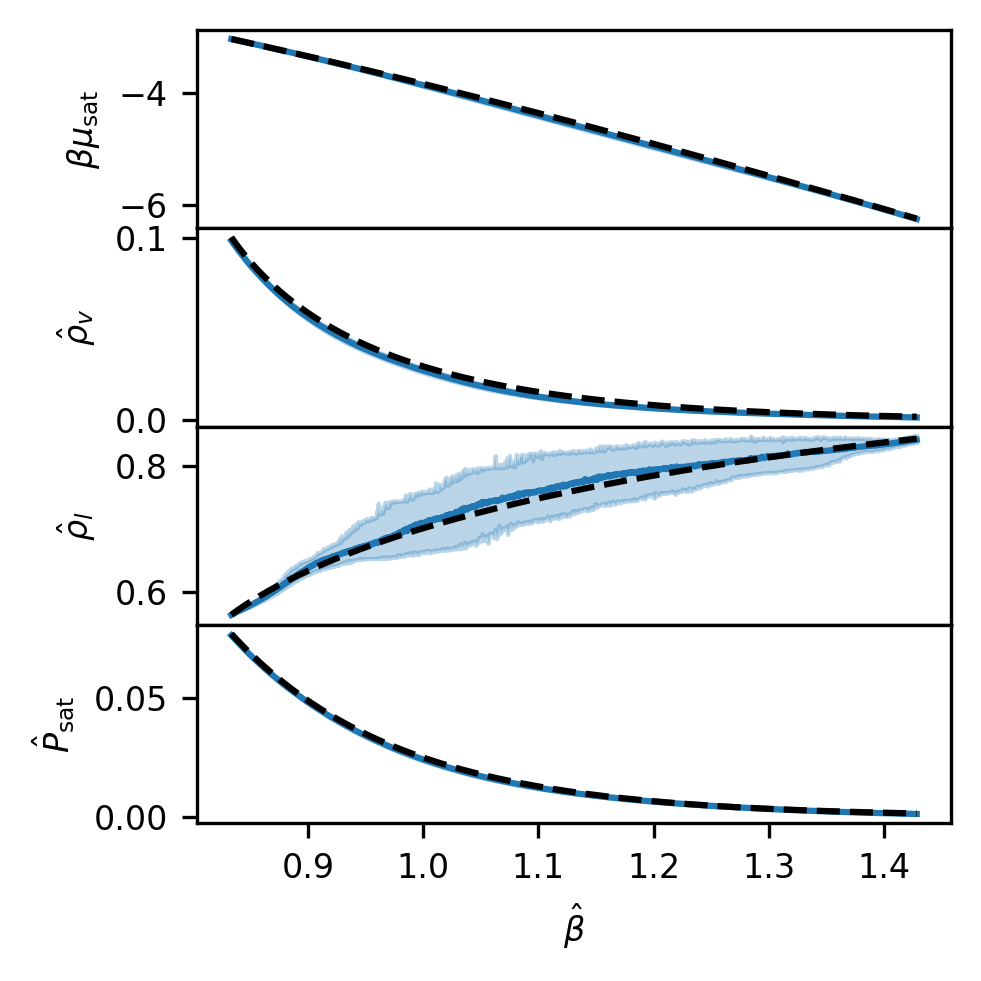

In [10]:
#Plot true values versus predicted properties
prop_betas = 1.0 / np.linspace(0.7, 1.2, 1000)

fig, ax = plt.subplots(gp_sat_props.shape[1]-1, sharex=True, sharey=False, figsize=(3.37, 3.37), dpi=300)

for i, prop in enumerate([raw_lnz, raw_dens[:, 0], raw_dens[:, 1], raw_psat]):
    ax[i].plot(prop_betas, gp_sat_props[:, i], color='tab:blue')
    ax[i].fill_between(prop_betas,
                       gp_sat_props_conf_ints[:, 0, i],
                       gp_sat_props_conf_ints[:, 1, i],
                       color='tab:blue', alpha=0.3)
    ax[i].plot(raw_beta, prop, 'k--')
    ax[i].tick_params(axis='both', labelsize=8)
    
ax[-1].set_xlabel(r'$\hat{\beta}$', fontsize=8)
ax[0].set_ylabel(r'$\beta \mu_\mathrm{sat}$', fontsize=8)
ax[1].set_ylabel(r'$\hat{\rho}_v$', fontsize=8)
ax[2].set_ylabel(r'$\hat{\rho}_l$', fontsize=8)
ax[3].set_ylabel(r'$\hat{P}_\mathrm{sat}$', fontsize=8)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()